# `banyan` Example 2: Training

This notebook goes through the full exercise of training a BNN on data.

## Python Preamble

Imports

In [1]:
from banyan import BNN, BLoss

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau as ReduceLR
from torch.utils.data import DataLoader, TensorDataset

Numpy RNG

In [2]:
rng = np.random.default_rng(42)

## Premise

Here I describe a 2-dimensional (1 input $x$, 1 output $y$) problem. The mean $\mu$ and scatter $\sigma$ of $y$ depend on $x$ as follows: 

In [3]:
def mu_true(x):
    return x - 0.5

def sig_true(x):
    return 2 * np.abs(x) / 3 + 0.5

To visualise this:

Text(0, 0.5, '$y$')

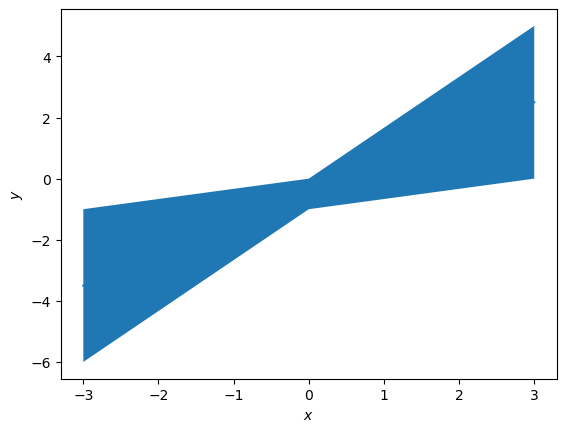

In [4]:
x = np.linspace(-3, 3, 500)
plt.plot(x, mu_true(x))
plt.fill_between(x, mu_true(x) - sig_true(x), mu_true(x) + sig_true(x))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

The idea is to sample a dataset following this relation, and train a BNN from it. The BNN should not only learn $\mu(x)$ but also $\sigma(x)$

## Data

Here I generate a mock dataset following the above relation, with inputs $x\in [-3, 3]$.

In [5]:
N_data = 100000

x = torch.tensor(rng.uniform(low=-3, high=3, size=(N_data, 1)))
y = torch.tensor(rng.normal(loc=mu_true(x), scale=sig_true(x)))

To visualise dataset, with true relations overplotted:

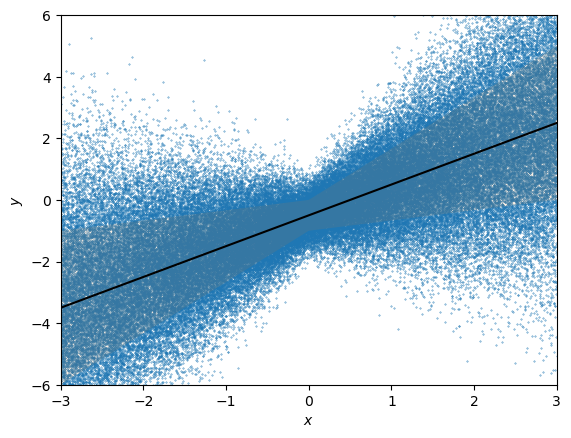

In [6]:
x_plot = np.linspace(-3, 3, 500)
mu_plot = mu_true(x_plot)
sig_plot = sig_true(x_plot)

plt.scatter(x, y, s=0.1)
plt.ylim(-6, 6)
plt.xlim(-3, 3)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.plot(x_plot, mu_plot, c='k')
plt.fill_between(x_plot, mu_plot-sig_plot, mu_plot+sig_plot, alpha=0.1)

## Set up model

Because the loss function can involve exponentials of large negative numbers, double precision is safer.

In [7]:
model = BNN(1, 1, 2, 8).double()
lossfn = BLoss()

## Train

Set up. Going to use batch size of 1000, with 50 samples on each forward pass. Using Adam optimiser and ReduceLROnPlateau for learning rate scheduling.

In [8]:
N_batch = 1000
N_samples = 50

optim = Adam(model.parameters(), lr=1e-3)
loader = DataLoader(TensorDataset(x, y), batch_size=N_batch, shuffle=True, drop_last=True, pin_memory=True)
scheduler = ReduceLR(optim, factor=0.5, min_lr=1e-6)

Training loop. Just going to do 50 epochs. At the end of every 5 epochs, make a scatter plot of prediction samples.

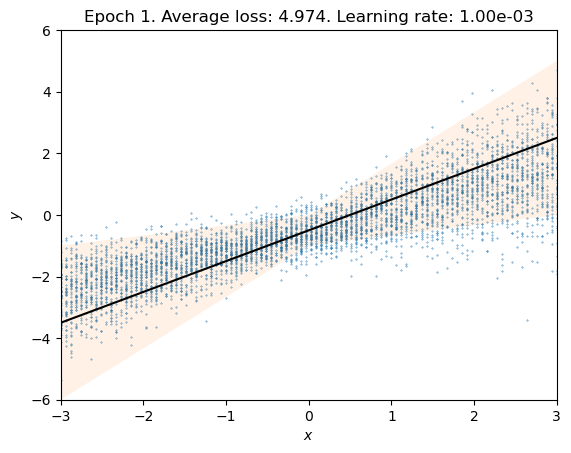

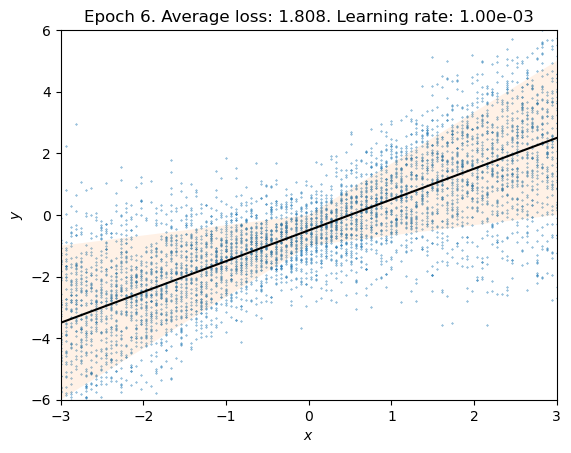

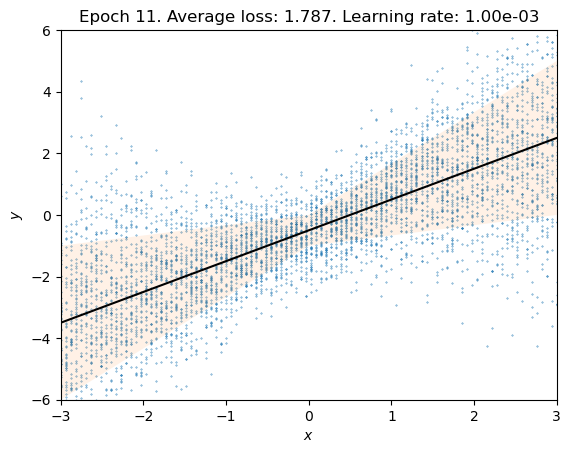

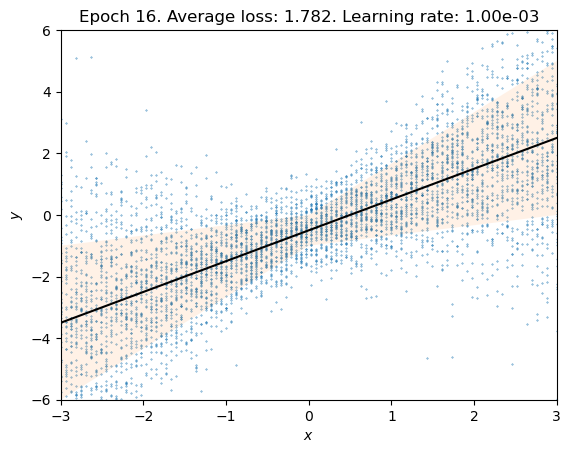

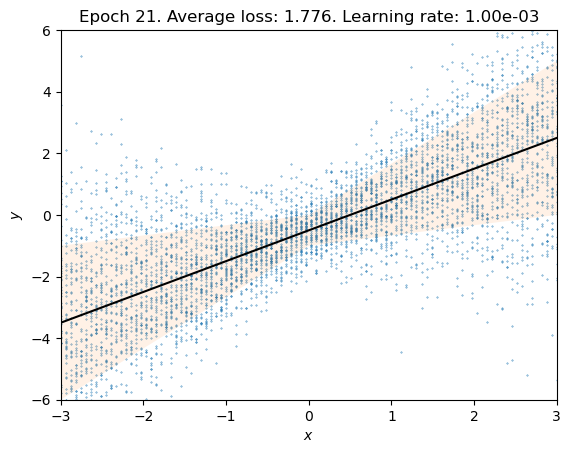

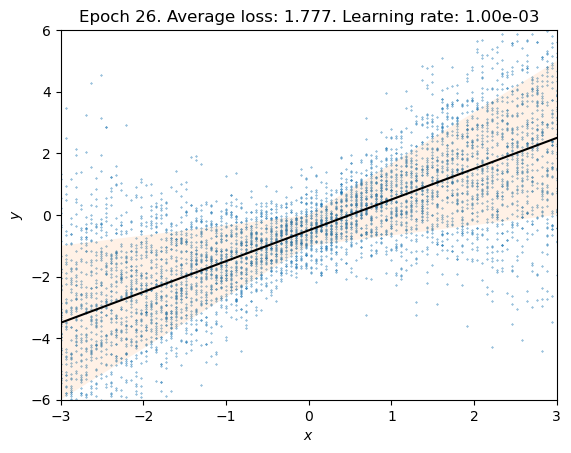

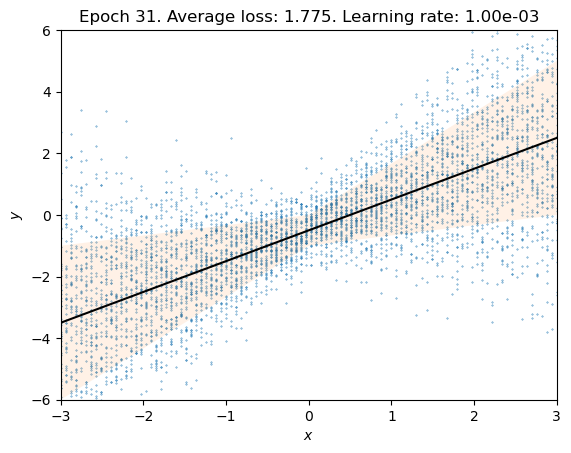

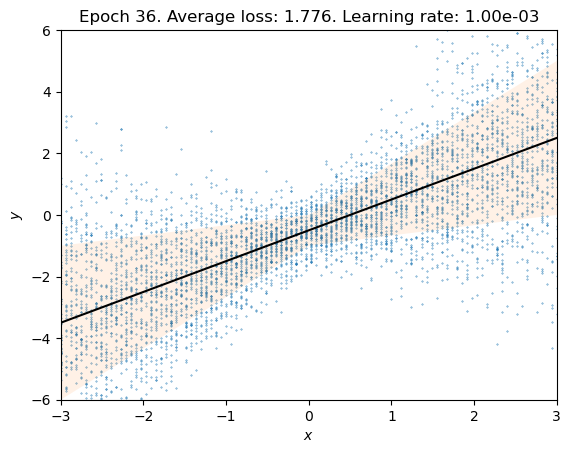

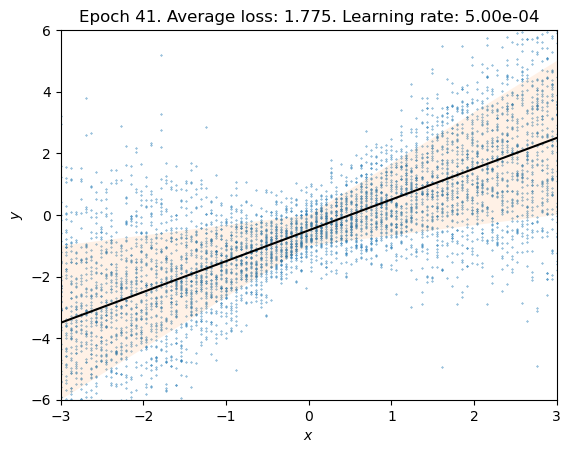

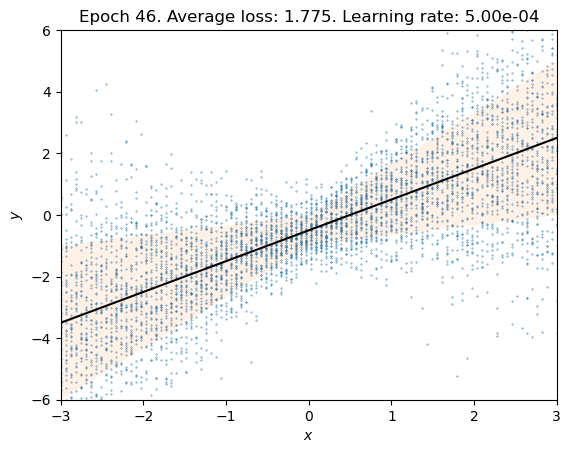

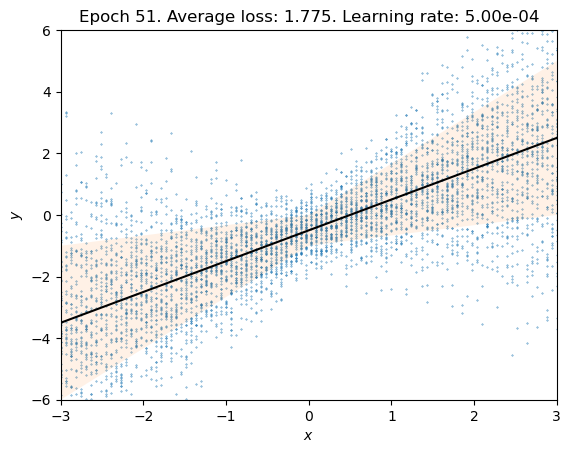

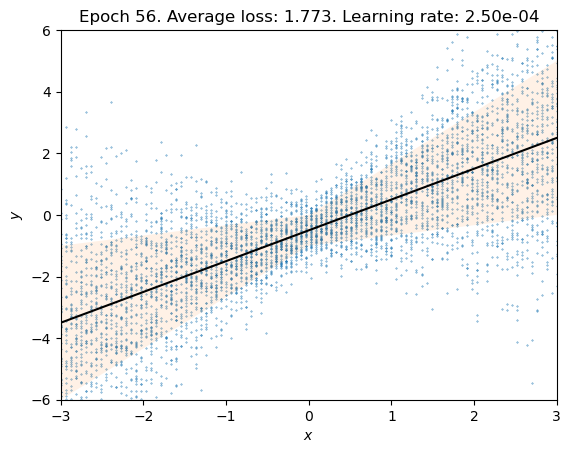

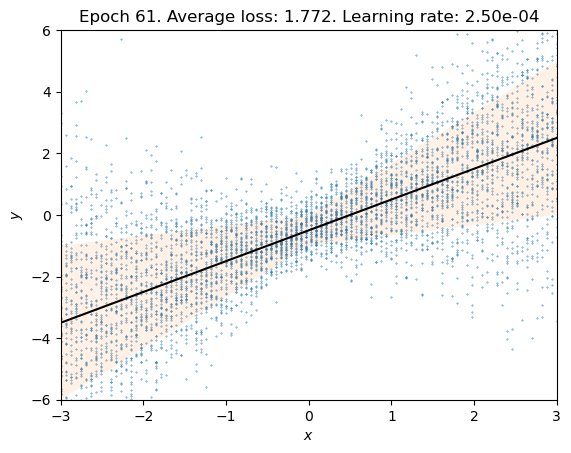

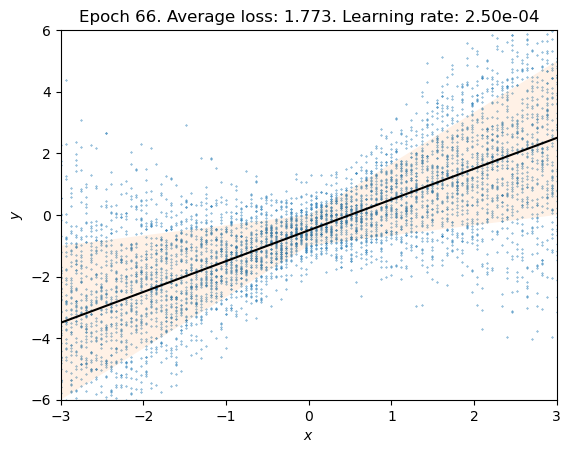

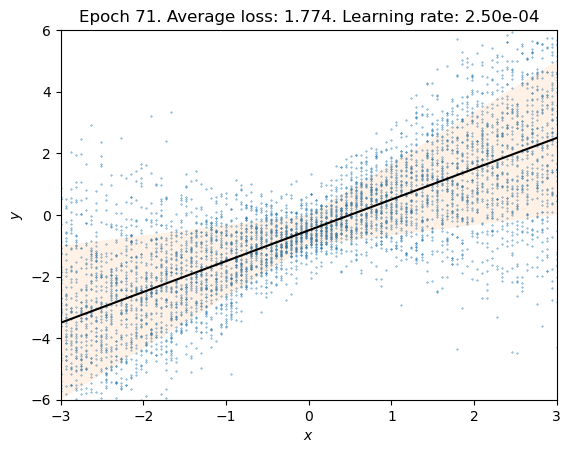

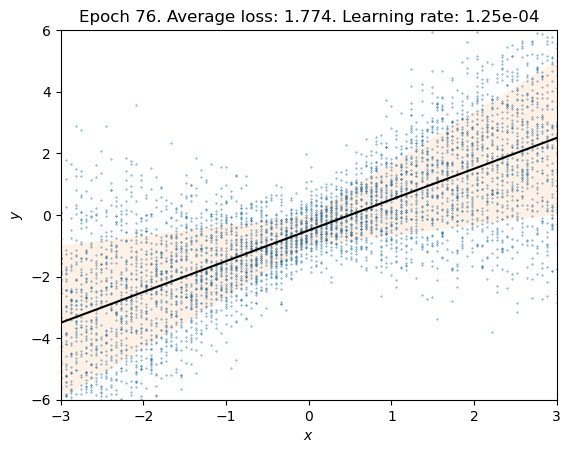

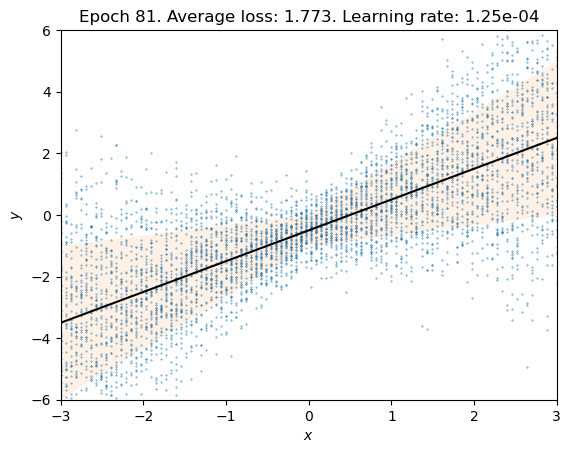

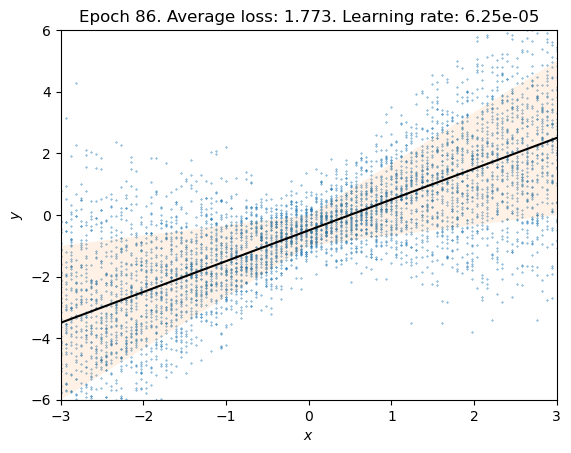

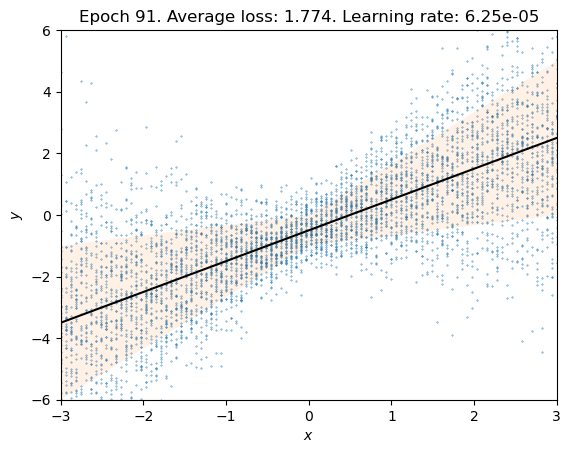

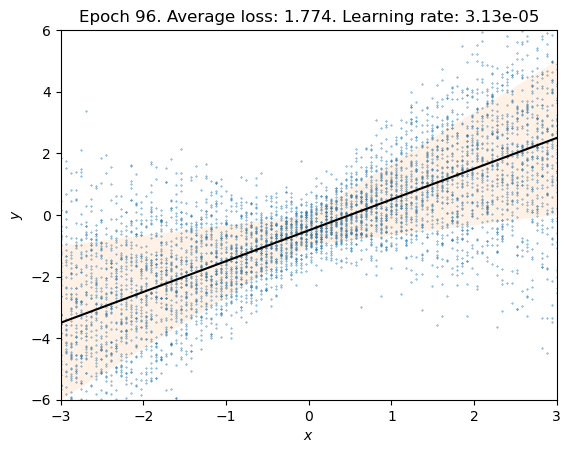

In [9]:
for i in range(100):

    # loop over train batches
    model.train()
    losses = np.array([])
    for x, y in loader:
        optim.zero_grad()
        preds = model(x, N_samples)
        loss = lossfn(preds, y)
        losses = np.append(losses, loss.item())
        loss.backward()
        optim.step()
    avg_loss = np.mean(losses)
    scheduler.step(avg_loss)
    lr = optim.param_groups[0]['lr']

    if i % 5 == 0:
        # make plot
        model.eval()
        Ns_test = 50
        x_test = torch.linspace(-3, 3, 100)[:, None]
        y_test = model(x_test, Ns_test)
        x_plot = torch.tile(x_test, dims=(1, Ns_test)).flatten().detach().numpy()
        y_plot = y_test.flatten().detach().numpy()

        plt.figure()
        plt.scatter(x_plot, y_plot, s=0.1)
        x_true = np.linspace(-3, 3, 500)
        y_true = mu_true(x_true)
        sigy_true = sig_true(x_true)
        plt.plot(x_true, y_true, c='k')
        plt.fill_between(x_true, y_true - sigy_true, y_true + sigy_true, alpha=0.1)
        plt.title(f"Epoch {i + 1}. Average loss: {avg_loss:.3f}. Learning rate: {lr:.2e}")
        plt.ylim(-6, 6)
        plt.xlim(-3, 3)
        plt.xlabel(r"$x$")
        plt.ylabel(r"$y$")
        plt.show()

## Evaluate

The training appears to have been successful, despite its brevity. Let us see whether it accurately estimates $\mu$ and $\sigma$ as a function of $x$.

In [10]:
Ns_test = 250
x = np.linspace(-3, 3, 100)
x_test = torch.from_numpy(x)[:, None]
y_test = model(x_test, Ns_test)
y = y_test.detach().numpy().squeeze()

First, $\mu$:

Text(0, 0.5, '$\\mu(x)$')

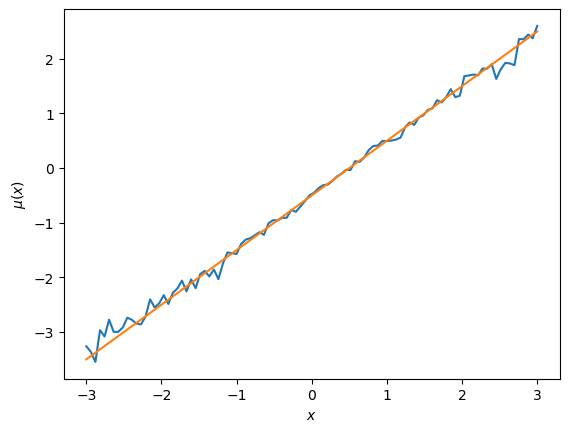

In [11]:
mu = np.mean(y, axis=-1)
plt.plot(x, mu)
plt.plot(x, mu_true(x))
plt.xlabel(r"$x$")
plt.ylabel(r"$\mu(x)$")

Now, $\sigma$:

Text(0, 0.5, '$\\sigma(x)$')

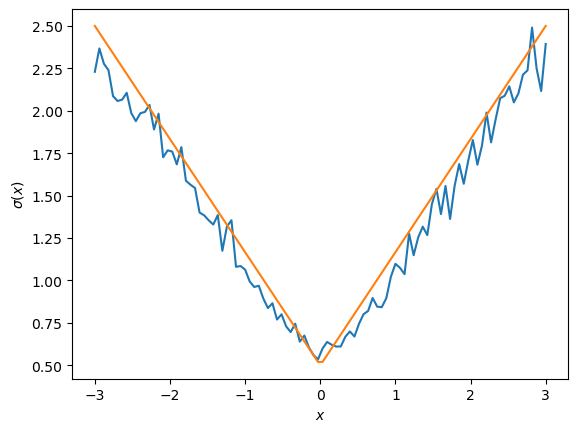

In [12]:
sig = np.std(y, axis=-1)
plt.plot(x, sig)
plt.plot(x, sig_true(x))
plt.xlabel(r"$x$")
plt.ylabel(r"$\sigma(x)$")

Looks good!